<a href="https://colab.research.google.com/github/BenWilop/WSG_games/blob/main/playground_WSG_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import dotenv
import wandb
import os

dotenv.load_dotenv(os.path.join("/homes/55/bwilop/wsg/private/", "vscode-ssh.env"))
api_key = os.getenv("WANDB_API_KEY")
wandb.login(key=api_key)
WANDB_ENTITIY = "benwilop-rwth-aachen-university"

data_folder = "/homes/55/bwilop/wsg/data/"
experiment_folder = "/homes/55/bwilop/wsg/experiments/"
crosscoder_folder = experiment_folder + "tictactoe/crosscoder/"

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /homes/55/bwilop/.netrc
wandb: Currently logged in as: benwilop (benwilop-rwth-aachen-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
%load_ext autoreload
%autoreload 2
import json
import torch as t
from torch.utils.data import DataLoader, TensorDataset
import datetime

# from jaxtyping import Float
import matplotlib.pyplot as plt

from wsg_games.tictactoe.evals import *
from wsg_games.tictactoe.data import *
from wsg_games.tictactoe.game import *

from wsg_games.tictactoe.analysis.analyse_data import *
from wsg_games.tictactoe.analysis.visualize_game import *

from wsg_games.tictactoe.train.create_models import *
from wsg_games.tictactoe.train.save_load_models import *
from wsg_games.tictactoe.train.train import *
from wsg_games.tictactoe.train.finetune import *
from wsg_games.tictactoe.train.pretrain import *

DEVICE = t.device("cuda" if t.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Load Data & Models

In [3]:
project_name_pretrain = "tictactoe/tictactoe_pretraining5"
project_name_finetune = "tictactoe/tictactoe_finetuning5"
weak_model_size = "small"
strong_model_size = "medium"
index = 2

# Load data
(
    tictactoe_train_data,
    tictactoe_weak_finetune_data,
    tictactoe_val_data,
    tictactoe_test_data,
) = load_split_data(data_folder + "tictactoe/", device=DEVICE, index=index)

# Load models
weak_model = load_model(
    project_name_pretrain,
    weak_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_baseline_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.WEAK_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
strong_model = load_model(
    project_name_pretrain,
    strong_model_size,
    Goal.STRONG_GOAL,
    experiment_folder,
    device=DEVICE,
    index=index,
)
finetuned_model = load_finetuned_model(
    project_name_finetune,
    weak_model_size,
    strong_model_size,
    experiment_folder,
    DEVICE,
    index,
)

# Print evaluations
(
    weak_loss,
    _,
) = quick_evaluation("weak_model", weak_model, tictactoe_test_data)
strong_baseline_loss, _ = quick_evaluation(
    "strong_baseline_model", strong_baseline_model, tictactoe_test_data
)
quick_evaluation("strong_model", strong_model, tictactoe_test_data)
weak_finetuned_loss, _ = quick_evaluation(
    "finetuned_model", finetuned_model, tictactoe_test_data
)
print(
    "Performance Gap Recovered (PGR): ",
    (weak_loss - weak_finetuned_loss) / (weak_loss - strong_baseline_loss),
)

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_small_weak_2025-05-16-16-35_ayyrg2xq.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_weak_2025-05-16-16-35_eif67e03.pkl
Moving model to device:  cuda
experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to

In [4]:
from dictionary_learning.dictionary_learning import CrossCoder
from dictionary_learning.dictionary_learning.dictionary import BatchTopKCrossCoder
from dictionary_learning.dictionary_learning.trainers.crosscoder import (
    BatchTopKCrossCoderTrainer,
)
from dictionary_learning.dictionary_learning.training import trainSAE
from dictionary_learning.dictionary_learning.cache import (
    PairedActivationCache,
    ActivationCache,
    ActivationShard,
)
import transformer_lens.utils as utils

In [5]:
def get_activations(
    model,
    tokenized_games: Float[Tensor, "n_games game_length"],
    layer_i: int,
) -> t.Tensor:
    activation_hook_name = utils.get_act_name("resid_post", layer_i)
    model.eval()
    _, cache = model.run_with_cache(tokenized_games)
    layer_activations = cache[activation_hook_name]
    return layer_activations

In [6]:
activation_hook_name = utils.get_act_name("resid_post", 1)
print(activation_hook_name)

blocks.1.hook_resid_post


In [7]:
@t.no_grad()
def create_data_shards(
    games_data: Float[Tensor, "n_games game_length"],
    model: HookedTransformer,
    store_dir: str,
    batch_size: int = 64,
    shard_size: int = 10**6,
    max_total_tokens: int = 10**8,
    overwrite: bool = False,
) -> None:
    dataloader = DataLoader(games_data, batch_size=batch_size)
    io: str = "out"
    submodule_names = [f"layer_{layer_i}" for layer_i in range(model.cfg.n_layers)]

    activation_cache = [[] for _ in submodule_names]
    store_dirs = [
        os.path.join(store_dir, f"{submodule_names[layer_i]}_{io}")
        for layer_i in range(len(submodule_names))
    ]
    for store_dir in store_dirs:
        os.makedirs(store_dir, exist_ok=True)
    total_size = 0
    current_size = 0
    shard_count = 0

    # Check if shards already exist
    if os.path.exists(os.path.join(store_dirs[0], "shard_0.memmap")):
        print(f"Shards already exist in {store_dir}")
        if not overwrite:
            print("Set overwrite=True to overwrite existing shards.")
            return
        else:
            print("Overwriting existing shards...")

    print("Collecting activations...")
    for games in tqdm(dataloader, desc="Collecting activations"):
        for layer_i in range(len(submodule_names)):
            local_activations = rearrange(
                get_activations(model, games, layer_i)
            )  # (B x T) x D
            activation_cache[layer_i].append(local_activations.cpu())

        current_size += activation_cache[0][-1].shape[0]
        if current_size > shard_size:
            print(f"Storing shard {shard_count}...", flush=True)
            ActivationCache.collate_store_shards(
                store_dirs,
                shard_count,
                activation_cache,
                submodule_names,
                shuffle_shards=True,
                io=io,
                multiprocessing=False,
            )
            shard_count += 1
            total_size += current_size
            current_size = 0
            activation_cache = [[] for _ in submodule_names]

        if total_size > max_total_tokens:
            print("Max total tokens reached. Stopping collection.")
            break

    if current_size > 0:
        ActivationCache.collate_store_shards(
            store_dirs,
            shard_count,
            activation_cache,
            submodule_names,
            shuffle_shards=True,
            io=io,
            multiprocessing=False,
        )

    # store configs
    for i, store_dir in enumerate(store_dirs):
        with open(os.path.join(store_dir, "config.json"), "w") as f:
            json.dump(
                {
                    "batch_size": batch_size,
                    "context_len": -1,
                    "shard_size": shard_size,
                    "d_model": model.cfg.d_model,
                    "shuffle_shards": True,
                    "io": io,
                    "total_size": total_size,
                    "shard_count": shard_count,
                    "store_tokens": False,
                },
                f,
            )
    ActivationCache.cleanup_multiprocessing()
    print(f"Finished collecting activations. Total size: {total_size}")

In [8]:
def get_activations_path(
    model_goal: Goal | None,
    weak_model_size: str | None,
    model_size: str,
    index: int,
    crosscoder_folder: str,
    train_val: str,
) -> str:
    assert model_goal is None or weak_model_size is None
    assert model_goal is not None or weak_model_size is not None
    if weak_model_size:
        postfix = "finetuned_through_" + weak_model_size
    elif model_goal in [Goal.WEAK_GOAL, Goal.STRONG_GOAL]:
        postfix = str(model_goal)
    else:
        raise ValueError(f"Invalid activations model goal: {model_goal}")
    return os.path.join(
        crosscoder_folder, "activations", f"{index}_{model_size}_{postfix}_" + train_val
    )


def compute_activations(
    model_goal: Goal | None,
    project_name_pretrain: str | None,
    weak_model_size: str | None,
    project_name_finetune: str | None,
    model_size: str,
    index: int,
    crosscoder_folder: str,
    tictactoe_test_data: Float[Tensor, "n_games game_length"],
    tictactoe_val_data: Float[Tensor, "n_games game_length"],
    experiment_folder: str,
) -> None:
    # Either finetuned or pretrained
    bool_finetuned_model = (
        project_name_finetune is not None and weak_model_size is not None
    )
    bool_pretrained_model = project_name_pretrain is not None and model_goal is not None
    assert int(bool_finetuned_model) + int(bool_pretrained_model) == 1, (
        f"Finetuned XOR pretrained model must be provided."
    )

    # Models
    if bool_finetuned_model:
        model = load_finetuned_model(
            project_name_finetune,
            weak_model_size,
            model_size,
            experiment_folder,
            DEVICE,
            index,
        )
    else:
        model = load_model(
            project_name_pretrain,
            model_size,
            model_goal,
            experiment_folder,
            device=DEVICE,
            index=index,
        )

    # Run
    for train_val in ["train", "val"]:
        if train_val == "train":
            games_data = tictactoe_test_data
        elif train_val == "val":
            games_data = tictactoe_val_data
        else:
            raise ValueError(f"Invalid train_val: {train_val}")

        activations_path = get_activations_path(
            model_goal, weak_model_size, model_size, index, crosscoder_folder, train_val
        )
        create_data_shards(
            games_data,
            model,
            store_dir=activations_path,
            batch_size=64,
            shard_size=10**5,
            max_total_tokens=10**10,
            overwrite=False,
        )

In [9]:
# Strong
compute_activations(
    Goal.STRONG_GOAL,
    project_name_pretrain,
    None,
    None,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
)

# Finetuned
compute_activations(
    None,
    None,
    weak_model_size,
    project_name_finetune,
    strong_model_size,
    index,
    crosscoder_folder,
    tictactoe_test_data.games_data,
    tictactoe_val_data.games_data,
    experiment_folder,
)

experiment_folder:  /homes/55/bwilop/wsg/experiments/
project_name:  tictactoe/tictactoe_pretraining5
/homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5
Loading model from /homes/55/bwilop/wsg/experiments/tictactoe/tictactoe_pretraining5/experiment_2_medium_strong_2025-05-16-16-44_omyjjb73.pkl
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_train/layer_3_out
Set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_strong_val/layer_3_out
Set overwrite=True to overwrite existing shards.
Moving model to device:  cuda
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medium_finetuned_through_small_train/layer_3_out
Set overwrite=True to overwrite existing shards.
Shards already exist in /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/activations/2_medi

In [10]:
def multi_epoch_dataloader_iterator(dataloader: DataLoader, total_steps_to_yield: int):
    """
    A generator that yields batches from a DataLoader repeatedly until
    total_steps_to_yield is reached. Re-shuffles if dataloader.shuffle=True.
    """
    # Edge cases
    if total_steps_to_yield == 0:  # No steps
        return
    try:
        if len(dataloader) == 0 and total_steps_to_yield > 0:  # Empty dataloader
            print(
                "Warning: DataLoader is empty, but total_steps_to_yield > 0. No steps will run."
            )
            return
    except TypeError:  # no __len__
        pass

    steps_yielded = 0
    while steps_yielded < total_steps_to_yield:
        num_batches_this_epoch = 0
        for batch in dataloader:  # DataLoader shuffles here if its shuffle=True
            if steps_yielded >= total_steps_to_yield:
                return
            yield batch
            steps_yielded += 1
            num_batches_this_epoch += 1

        # Safeguard, if the dataloader gets empty for any reason, it would be an infinite loop otherwise
        if num_batches_this_epoch == 0 and steps_yielded < total_steps_to_yield:
            print("Warning: DataLoader became empty before all steps were yielded.")
            return

In [11]:
def get_training_cfg_cross_coder():
    training_cfg_cross_coder = {
        "learning_rate": 1e-3,
        "max_steps": 20000,
        "validate_every_n_steps": 1000,
        "batch_size": 64,
        "expansion_factor": 32,
        "k": 10,
    }
    return training_cfg_cross_coder


def train_crosscoder(
    model_1_name: str,
    model_2_name: str,
    index: int,
    train_activations_stor_dir_model_1: str,
    val_activations_stor_dir_model_1: str,
    train_activations_stor_dir_model_2: str,
    val_activations_stor_dir_model_2: str,
    layer: int,
    training_cfg_cross_coder: dict,
    wandb_entity: str,
) -> None:
    # Data (not loaded in memory yet)
    train_dataset = PairedActivationCache(
        train_activations_stor_dir_model_1,
        train_activations_stor_dir_model_2,
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=training_cfg_cross_coder["batch_size"],
        shuffle=True,
        num_workers=1,
        pin_memory=True,
    )
    print(f"Training on {len(train_dataset)} token activations.")
    val_dataset = PairedActivationCache(
        val_activations_stor_dir_model_1,
        val_activations_stor_dir_model_2,
    )
    val_dataloader = DataLoader(
        val_dataset,
        batch_size=1000,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
    )
    print(f"Validating on {len(val_dataset)} token activations.")

    # Training config
    activation_dim = train_dataset[0].shape[1]
    dictionary_size = training_cfg_cross_coder["expansion_factor"] * activation_dim
    print(f"Activation dim: {activation_dim}")
    print(f"Dictionary size: {dictionary_size}")
    k = training_cfg_cross_coder["k"]
    lr = training_cfg_cross_coder["learning_rate"]
    max_steps = training_cfg_cross_coder["max_steps"]
    timestamp = datetime.now().strftime("%Y-%m-%d-%H-%M")
    experiment_name = f"experiment_{index}_{model_1_name}_{model_2_name}_{timestamp}"

    # Top level of trainer_cfg: BatchTopKCrossCoderTrainer
    # dict_class_kwargs: CrossCoder
    trainer_cfg = {
        "trainer": BatchTopKCrossCoderTrainer,
        "activation_dim": activation_dim,
        "dict_size": dictionary_size,
        "lr": lr,
        "device": str(DEVICE),
        "wandb_name": experiment_name + f"L{layer}-k{k:.1e}-lr{lr:.0e}",  #
        "steps": max_steps,  # Also used below, I think because it is needed here for learning rate and in trainSAE just for loop termination
        "k": k,  # 'k' as a top-level argument for the trainer
        "layer": layer,  # Only for logging
        "lm_name": experiment_name,  # Only for logging
        # "dict_class_kwargs": {
        # },
    }

    # train the sparse autoencoder (SAE)
    wandb.finish()
    multi_epoch_train_dataloader = multi_epoch_dataloader_iterator(
        train_dataloader, max_steps
    )
    ae = trainSAE(
        data=multi_epoch_train_dataloader,
        trainer_config=trainer_cfg,
        validate_every_n_steps=training_cfg_cross_coder["validate_every_n_steps"],
        validation_data=val_dataloader,
        use_wandb=True,
        wandb_entity=wandb_entity,
        wandb_project="crosscoder",
        log_steps=50,
        save_dir=crosscoder_folder + "checkpoints/" + experiment_name,
        steps=max_steps,
        save_steps=None,
    )

In [12]:
layer = 3

model_1_name = "strong_model"
model_2_name = "finetuned_model"

train_activations_stor_dir_model_1 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_1 = get_activations_path(
    Goal.STRONG_GOAL, None, strong_model_size, index, crosscoder_folder, "val"
)
train_activations_stor_dir_model_2 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "train"
)
val_activations_stor_dir_model_2 = get_activations_path(
    None, weak_model_size, strong_model_size, index, crosscoder_folder, "val"
)
training_cfg_cross_coder = get_training_cfg_cross_coder()
# train_crosscoder(
#     model_1_name,
#     model_2_name,
#     index,
#     train_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_1 + f"/layer_{layer}_out",
#     train_activations_stor_dir_model_2 + f"/layer_{layer}_out",
#     val_activations_stor_dir_model_2 + f"/layer_{layer}_out",
#     layer,
#     training_cfg_cross_coder,
#     WANDB_ENTITIY,
# )

Delta norms plot saved to /homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-23-20-27/delta_norms.png


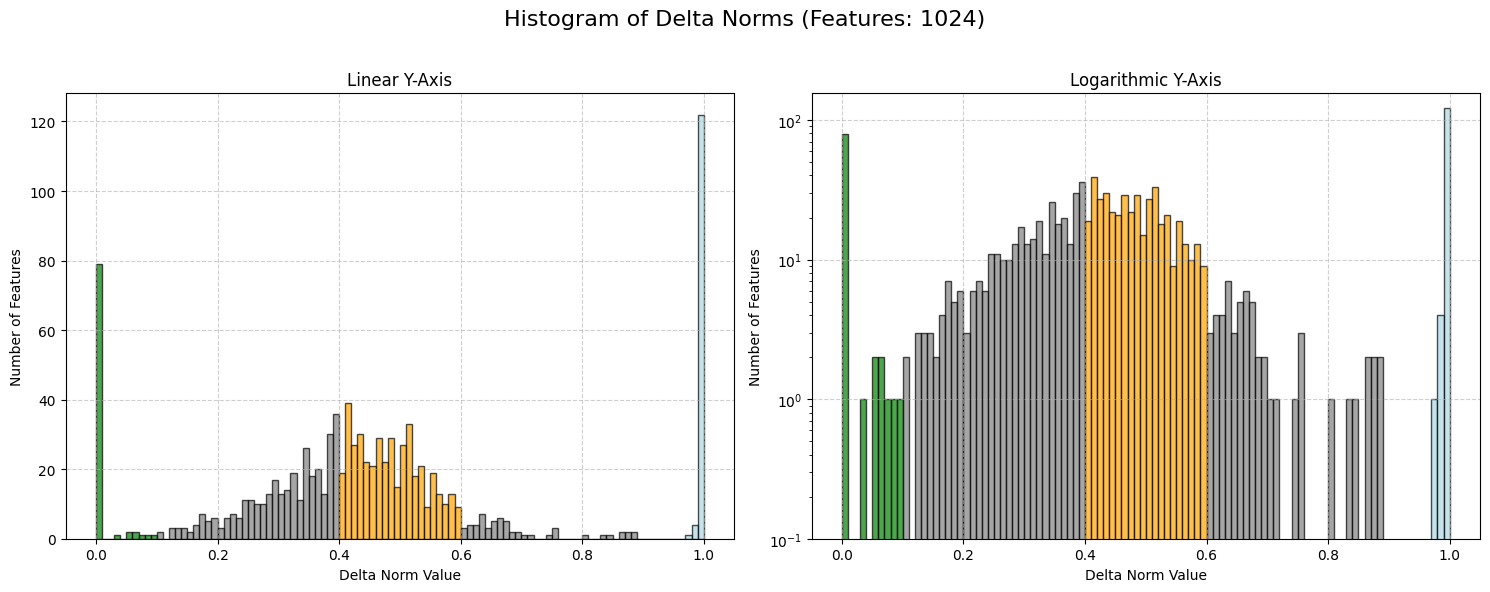

In [18]:
@dataclass
class CrosscoderMetrics:
    save_dir: str
    config: dict
    crosscoder: BatchTopKCrossCoder
    delta_norms: Float[Tensor, "n_activations"]
    beta_reconstruction_model_1: Float[Tensor, "n_activations"]
    beta_reconstruction_model_2: Float[Tensor, "n_activations"]
    beta_error_model_1: Float[Tensor, "n_activations"]
    beta_error_model_2: Float[Tensor, "n_activations"]
    nu_reconstruction: Float[Tensor, "n_activations"]
    nu_error: Float[Tensor, "n_activations"]

    def __init__(self, save_dir: str, val_dataloader: DataLoader) -> None:
        self.save_dir = save_dir
        self.config = self.load_config(self.save_dir)
        self.crosscoder = self.load_model(self.save_dir)
        self.delta_norms = self.compute_delta_norms()
        self.beta_reconstruction_model_1, self.beta_error_model_1 = self.compute_beta(
            model_i=0, val_dataloader=val_dataloader
        )
        self.beta_reconstruction_model_2, self.beta_error_model_2 = self.compute_beta(
            model_i=1, val_dataloader=val_dataloader
        )
        self.nu_reconstruction = (
            self.beta_reconstruction_model_1 / self.beta_reconstruction_model_2
        )
        self.nu_error = self.beta_error_model_1 / self.beta_error_model_2
        self.plot_delta_norms()
        self.plot_betas()
        self.plot_nu()

    # Save + Load
    def save(self, save_dir: str) -> None:
        path = os.path.join(save_dir, "crosscoder_metric.pt")
        with open(path, "wb") as f:
            pickle.dump(self, f)

    def _load_helper(path: str):
        if os.path.exists(path):
            with open(path, "rb") as f:
                data = pickle.load(f)
            return data
        else:
            raise FileNotFoundError(f"File {path} not found.")

    @staticmethod
    def load(save_dir: str):  # -> CrosscoderMetrics
        path = os.path.join(save_dir, "crosscoder_metric.pt")
        return CrosscoderMetrics._load_helper(path)

    @staticmethod
    def load_config(save_dir: str) -> dict:
        path = os.path.join(save_dir, "config.json")
        if os.path.exists(path):
            with open(path, "r") as f:
                data = json.load(f)
            return data.get("trainer", {})
        else:
            raise FileNotFoundError(f"File {path} not found.")

    @staticmethod
    def load_model(save_dir: str) -> CrossCoder:
        path = os.path.join(save_dir, "model_final.pt")
        if os.path.exists(path):
            return BatchTopKCrossCoder.from_pretrained(path, device=DEVICE)
        else:
            raise FileNotFoundError(f"File {path} not found.")

    def compute_delta_norms(
        self, epsilon: float = 0.0001
    ) -> Float[Tensor, "n_activations"]:
        d_model_1_vectors = self.crosscoder.decoder.weight[0]
        d_model_2_vectors = self.crosscoder.decoder.weight[1]
        norm_sq_model1 = t.sum(d_model_1_vectors**2, dim=-1)
        norm_sq_model2 = t.sum(d_model_2_vectors**2, dim=-1)
        max_norms_sq = t.maximum(norm_sq_model1, norm_sq_model2)

        delta_norms = 0.5 * (
            (norm_sq_model2 - norm_sq_model1) / (max_norms_sq + epsilon) + 1.0
        )
        return delta_norms.cpu()

    def compute_beta(
        self, model_i: int, val_dataloader: DataLoader
    ) -> tuple[Float[Tensor, "n_activations"], Float[Tensor, "n_activations"]]:
        return 1.0, 1.0  # compute the beta reconstruction and error for model_i

    def plot_delta_norms(
        self, threshold_only: float = 0.1, threshold_shared: float = 0.1
    ):  # -> matplotlib plot that can be easily added to another plot as a subplot
        # Thresholds
        threshold_model_1_only = threshold_only
        threshold_model_2_only = 1 - threshold_only
        threshold_shared_lower = 0.5 - threshold_shared
        threshold_shared_upper = 0.5 + threshold_shared
        assert (
            threshold_model_1_only
            < threshold_shared_lower
            < threshold_shared_upper
            < threshold_model_2_only
        ), (
            f"Invalid thresholds: {threshold_model_1_only}, {threshold_shared_lower}, {threshold_shared_upper}, {threshold_model_2_only}"
        )

        # Data
        data_to_plot = self.delta_norms.detach().numpy()
        bins = np.linspace(0, 1, 101)  # 100 bins from 0 to 1, [0, 0.01, 0.02, ..., 1.0]

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle(
            f"Histogram of Delta Norms (Features: {len(data_to_plot)})", fontsize=16
        )
        titles = ["Linear Y-Axis", "Logarithmic Y-Axis"]
        y_scales = ["linear", "log"]
        for i, ax in enumerate(axes):
            counts, _, patches = ax.hist(
                data_to_plot, bins=bins, edgecolor="black", alpha=0.7
            )
            bin_centers = (bins[:-1] + bins[1:]) / 2
            for count, patch, bin_center in zip(counts, patches, bin_centers):
                if bin_center <= threshold_model_1_only:
                    patch.set_facecolor("green")
                elif bin_center >= threshold_model_2_only:
                    patch.set_facecolor("lightblue")
                elif threshold_shared_lower <= bin_center <= threshold_shared_upper:
                    patch.set_facecolor("orange")
                else:
                    patch.set_facecolor("grey")

            ax.set_title(titles[i])
            ax.set_xlabel("Delta Norm Value")
            ax.set_ylabel("Number of Features")
            ax.set_yscale(y_scales[i])
            if y_scales[i] == "log":
                ax.set_ylim(bottom=0.1)  # Avoid log(0)
            ax.grid(True, linestyle="--", alpha=0.6)

        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Save plot
        filename = f"delta_norms.png"
        if self.save_dir:
            os.makedirs(self.save_dir, exist_ok=True)
            save_path = os.path.join(self.save_dir, filename)
            try:
                fig.savefig(save_path)
                print(f"Delta norms plot saved to {save_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")

        return fig, axes

    def plot_betas(self):
        pass
        # Ignore for now

    def plot_nu(self):
        pass
        # Ignore for now


save_dir = "/homes/55/bwilop/wsg/experiments/tictactoe/crosscoder/checkpoints/experiment_2_strong_model_finetuned_model_2025-05-23-20-27"
val_dataloader = DataLoader(
    tictactoe_val_data.games_data,
    batch_size=1000,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)
crosscoder_metrics = CrosscoderMetrics(save_dir, val_dataloader)